## Анализ эффективности удержания

**1.** В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний  о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:
* state — штат США
* account_length — длительность использования аккаунта
* area_code — деление пользователей на псевдорегионы, использующееся в телекоме
* intl_plan — подключена ли у пользователя услуга международного общения
* vmail_plan — подключена ли у пользователя услуга голосовых сообщений
* vmail_message — количество голосых сообщений, который пользователь отправил / принял
* day_calls — сколько пользователь совершил дневных звонков
* day_mins — сколько пользователь проговорил минут в течение дня
* day_charge — сколько пользователь заплатил за свою дневную активность
* eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
* night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
* intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
* custserv_calls — сколько раз пользователь позвонил в службу поддержки
* treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
* mes_estim — оценка интенсивности пользования интернет мессенджерами
* churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy 
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests 

In [3]:
data = pd.read_csv('data/churn_analysis.csv', header=0)
data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [4]:
data['churn'] = data['churn'].apply(lambda x: 1 if x=='True.' else 0)

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора. 

Для этого мы воспользуемся критерием хи-квадрат.  Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.  

Сколько  достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [5]:
control_group = data[data.loc[:, 'treatment']==1]

In [6]:
states = control_group['state'].unique()
control_states = pd.pivot_table(
    control_group,
    values=["treatment"],
    index=["state"],
    columns=["churn"],
    fill_value = 0,
    aggfunc='count')

In [7]:
cell_less_5_count = np.sum(control_states < 5)[1]
print(f'Количество ячеек таблицы, с числом значений < 5: {cell_less_5_count}')
print(f'Процент ячеек от общего числа:\
{cell_less_5_count * 100 / (control_states.shape[0] * control_states.shape[1])}%')

Количество ячеек таблицы, с числом значений < 5: 34
Процент ячеек от общего числа:33.333333333333336%


In [8]:
scipy.stats.chi2_contingency(control_states.loc[['KS','OH'],:], correction=False)[0:2]

(3.158685185185184, 0.07552398753331192)

In [9]:
chi_data = []

for i, lhs_column in enumerate(states):
    for j, rhs_column in enumerate(states):
        if i >= j:
            continue
        
        statistic, p = scipy.stats.chi2_contingency(
            control_states.loc[[lhs_column, rhs_column],:],
            correction=False)[0:2]
        reject = True if p < 0.05 else False
        chi_data.append([lhs_column, rhs_column, statistic, p, reject])

In [10]:
chi_data = pd.DataFrame(chi_data)
chi_data.columns = ['state_A', 'state_B', 'chi2', 'p', 'reject']

In [11]:
chi_data.head()

,state_A,state_B,chi2,p,reject
0,KS,OH,3.158685,0.075524,False
1,KS,LA,5.090909,0.024052,True
2,KS,IA,1.156511,0.282190,False
3,KS,VT,0.250435,0.616769,False
4,KS,CO,0.171113,0.679125,False


In [12]:
print(f'Количество пар штатов для которых \
достигаемый уровень значимости < 0.5: \
{chi_data.reject.sum()}')

Количество пар штатов для которых достигаемый уровень значимости < 0.5: 34


**2.** Какие проблемы Вы видите в построении анализа  из первого вопроса? Отметьте все верные утверждения. 

* Интерпретация числа достигаемых уровней значимости,  меньших $\alpha=0.05$, некорректна,  поскольку не сделана поправка на множественную проверку гипотез.
* Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты. 

**3.** В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в  таблице сопряженности  может быть аппроксимировано с помощью непрерывного распределения xи-квадрат.  Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность.  Эта поправка заключается в  вычитании константы 0.5  из каждого модуля разности наблюденного  $O_i$ и ожидаемого  $E_i$ значений, то есть, статистика с такой поправкой выглядит так: 
$$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}.$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает  значение статистики  $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2  и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода). 

Полезно знать, что эта поправка часто включена по  умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости. 

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией и сравните полученные результаты, отметив все верные варианты.


In [13]:
chi_corr_data = []

for i, lhs_column in enumerate(states):
    for j, rhs_column in enumerate(states):
        if i >= j:
            continue
        
        statistic, p = scipy.stats.chi2_contingency(
            control_states.loc[[lhs_column, rhs_column],:],
            correction=True)[0:2]
        reject = True if p < 0.05 else False
        chi_corr_data.append([statistic, p, reject])

In [14]:
chi_data[['chi2_corr','p_corr', 'reject_corr']] = chi_corr_data

In [15]:
chi_data.head()

,state_A,state_B,chi2,p,reject,chi2_corr,p_corr,reject_corr
0,KS,OH,3.158685,0.075524,False,1.983196,0.159054,False
1,KS,LA,5.090909,0.024052,True,3.336219,0.067770,False
2,KS,IA,1.156511,0.282190,False,0.468339,0.493752,False
3,KS,VT,0.250435,0.616769,False,0.027826,0.867518,False
4,KS,CO,0.171113,0.679125,False,0.006155,0.937468,False


**Вывод:** 
1. Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений  достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.

In [16]:
chi_data['reject_corr'].sum()

0

2. Поправка Йетса на непрерывность всегда увеличивает значение  достигаемого уровня значимости, поэтому все получившиеся значения  достигаемого уровня значимости строго больше  или равны таковым значениям при отсутствии этой поправки. - **неверно**

In [17]:
np.sum(chi_data['p'] > chi_data['p_corr'])

192

3. Количество  достигаемых уровней значимости, меньших, чем 0.05, почти не изменилось, нельзя сказать, что введенная  поправка сильно поменяла достигаемые уровни значимости. - **неверно**

In [18]:
chi_data['reject'].sum()

34

4. Достигаемые уровни значимости на наших данных,  полученные с помощью критерия xи-квадрат с поправкой Йетса,  в среднем получаются больше, чем соответствующие значения  без поправки.

In [19]:
np.sum(chi_data['p'] < chi_data['p_corr'])

1054

**4.** Что если у нас мало данных,  мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку,  предположения  критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно?

В таком случае прибегают к так называемому точному критерию Фишера. Этот  критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

 $  $  |$Группа 1$|$Группа 2$|$\Sigma$
-----|--------|--------|--------|
$Воздействие 1$|$a$|$b$|$a + b$|
$Воздействие 2$|$c$|$d$|$c + d$|
$\Sigma$| $a + c$|$b + d$|$n = a + b + c + d$|

Тогда вероятность получить именно такие $a, b, c, d$ при фиксированных значениях сумм по строкам и по столбцам) задается выражением

$$p={\frac {\displaystyle {{a+b} \choose {a}}\displaystyle {{c+d} \choose {c}}}{\displaystyle {{n} \choose {a+c}}}}={ \dfrac {(a+b)!~(c+d)!~(a+c)!~(b+d)!}{a!~~b!~~c!~~d!~~n!}}.$$

В числителе этой дроби стоит суммарное количество способов выбрать $a$ и $c$ из $a+b$ и $c+d$ соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца $a+c$ из общего количества рассматриваемых объектов $n$.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения $a, b, c, d$ в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора $a, b, c, d$ нужно вычислить значение  $p_i$ по формуле выше и просуммировать все такие значения  $p_i$, которые меньше или равны  $p$, которое мы вычислили по наблюдаемым значениям $a, b, c, d$.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы $n\times m$.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции scipy.stats.fisher_exact которая принимает на вход таблицу сопряженности 2x2. 

In [20]:
fisher_data = []

for i, lhs_column in enumerate(states):
    for j, rhs_column in enumerate(states):
        if i >= j:
            continue
        
        statistic, p = scipy.stats.fisher_exact(
            control_states.loc[[lhs_column, rhs_column],:])[0:2]
        reject = True if p < 0.05 else False
        fisher_data.append([p, reject])

In [21]:
chi_data[['p_fisher', 'reject_fisher']] = fisher_data

In [22]:
chi_data.head()

,state_A,state_B,chi2,p,reject,chi2_corr,p_corr,reject_corr,p_fisher,reject_fisher
0,KS,OH,3.158685,0.075524,False,1.983196,0.159054,False,0.138333,False
1,KS,LA,5.090909,0.024052,True,3.336219,0.067770,False,0.032840,True
2,KS,IA,1.156511,0.282190,False,0.468339,0.493752,False,0.440083,False
3,KS,VT,0.250435,0.616769,False,0.027826,0.867518,False,0.743389,False
4,KS,CO,0.171113,0.679125,False,0.006155,0.937468,False,0.747108,False


**Вывод:**
1. Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.
2. Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем большие, чем xи-квадрат без поправки

In [23]:
np.sum(chi_data['p'] > chi_data['p_fisher'])

2

3. Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса

In [24]:
np.sum(chi_data['p_corr'] > chi_data['p_fisher'])

767

**5.** Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике. 

Рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

Отметьте все верные утверждения. 

In [25]:
pears_r, p_pears = stats.pearsonr(data['day_calls'],
                                  data['mes_estim'])
print(f'Коэффициент корреляции: {pears_r}')
print(f'p-value: {p_pears}')

Коэффициент корреляции: -0.05179435058757252
p-value: 0.0027798836869732313


**Вывод:**
1. Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. 

**6.** Еще раз рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения. 

In [26]:
spear_r, spear_p =stats.spearmanr(data['day_calls'],
                                      data['mes_estim'])
print(f'Коэффициент корреляции: {spear_r}')
print(f'p-value: {spear_p}')

Коэффициент корреляции: 0.043349880533927444
p-value: 0.012317367189170543


**Вывод:**
1. Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. 

**7.** Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

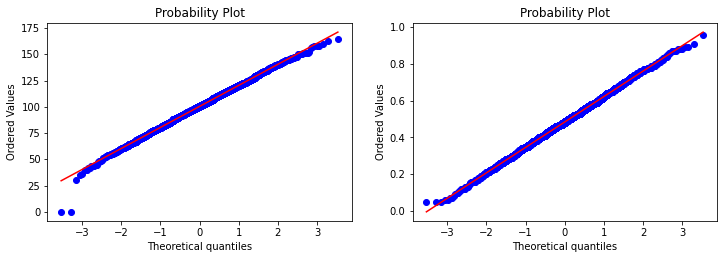

In [27]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)

stats.probplot(data['day_calls'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(data['mes_estim'], dist="norm", plot=plt)
plt.show()

**Вывод:**
1. Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

**8.** Посчитайте значение коэффицента корреляции Крамера между двумя признаками:  штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1).  Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [28]:
def v_Cramer_correlation(table):
    chi_stat = stats.chi2_contingency(table)
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat[0]/(n*(k_min-1))), chi_stat[1]

v_cramer, p_cramer = v_Cramer_correlation(control_states.values)
print(f'V-Cramer statistic is: {np.round(v_cramer, 4)}') 
print(f'V-Cramer p-value: {np.round(p_cramer, 4)}') 

V-Cramer statistic is: 0.2004
V-Cramer p-value: 0.7098


**Вывод:**
1. Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным. 

**9.** Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение. 

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1). 

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку!  И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы  (treatment = 0, treatment = 2) !

**Для анализа эффективности применим Z-критерий для разности долей (независимые выборки):**

In [29]:
treatment_0 = data[data.loc[:, 'treatment']==0]['churn']
treatment_1 = control_group['churn']
treatment_2 = data[data.loc[:, 'treatment']==2]['churn']

In [30]:
conf_interval_control = proportion_confint(sum(treatment_1), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_treatment_0 = proportion_confint(sum(treatment_0), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_treatment_2 = proportion_confint(sum(treatment_2), 
                                            data.shape[0],
                                            method = 'wilson')

In [31]:
print(f'95% доверительный интервал для оттока в контрольой группе: {conf_interval_control}')
print(f'95% доверительный интервал для оттока в группе 0: {conf_interval_treatment_0}')
print(f'95% доверительный интервал для оттока в группе 2: {conf_interval_treatment_2}')

95% доверительный интервал для оттока в контрольой группе: (0.046832593769958165, 0.06220508851455855)
95% доверительный интервал для оттока в группе 0: (0.04264529311470613, 0.057401851150481804)
95% доверительный интервал для оттока в группе 2: (0.03515191803549811, 0.04871225779489799)


In [32]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [33]:
print(f'95% доверительный интервал для разностей долей \
оттока в группе 0 и контрольой группе: \
{np.round(proportions_diff_confint_ind(treatment_0, treatment_1), 4)}')
print(f'95% доверительный интервал для разностей долей \
оттока в группе 2 и контрольой группе: \
{np.round(proportions_diff_confint_ind(treatment_2, treatment_1), 4)}')
print(f'95% доверительный интервал для разностей долей \
оттока в группе 2 и группе 0: \
{np.round(proportions_diff_confint_ind(treatment_2, treatment_0), 4)}')

95% доверительный интервал для разностей долей оттока в группе 0 и контрольой группе: [-0.0485  0.0116]
95% доверительный интервал для разностей долей оттока в группе 2 и контрольой группе: [-0.0683 -0.0096]
95% доверительный интервал для разностей долей оттока в группе 2 и группе 0: [-0.0489  0.0078]


In [34]:
p_0_1 = np.round(
    proportions_diff_z_test(
        proportions_diff_z_stat_ind(treatment_0,
                                    treatment_1)),
    4)
p_2_1 = np.round(
    proportions_diff_z_test(
        proportions_diff_z_stat_ind(treatment_2,
                                    treatment_1)),
    4) 
p_2_0 = np.round(
    proportions_diff_z_test(
        proportions_diff_z_stat_ind(treatment_0,
                                    treatment_2)),
    4)

print(f'Достигаемый уровень значимости для разностей долей \
оттока в группе 0 и контрольой группе: \
{p_0_1}')
print(f'Достигаемый уровень значимости для разностей долей \
оттока в группе 2 и контрольой группе: \
{p_2_1}')
print(f'Достигаемый уровень значимости для разностей долей \
оттока в группе 2 и группе 0: \
{p_2_0}')

Достигаемый уровень значимости для разностей долей оттока в группе 0 и контрольой группе: 0.2283
Достигаемый уровень значимости для разностей долей оттока в группе 2 и контрольой группе: 0.0093
Достигаемый уровень значимости для разностей долей оттока в группе 2 и группе 0: 0.1564


**Вывод:**
1. treatment = 2 статистически значимо отличается от контрольной  группы treatment = 1
2. Отличие  между  treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо. 